In [81]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Load in the Horizon AGN simulations

In [10]:
file_agn = 'Hz-AGN_powerspec.out'
file_no_agn = 'Hz-noAGN_powerspec.out'
file_dm = 'Hz-DM_powerspec.out'

In [152]:
def read_file(file_in,z_index=0):
    with open(file_in,"r") as infile:
        for l,line in enumerate(infile):
            if l==0:
                continue
            if l>1:
                break
            z = float((line.split()[1].split(','))[z_index+1].split('=')[1])
    k,cal_pk = np.loadtxt(file_in,usecols=[0,z_index+1],unpack=True)
    pk = (2.*np.pi**2.)*cal_pk/(k**3.)
    return z,k,pk

In [227]:
z_index = 0
z_agn,k_agn,pk_agn = read_file(file_agn,z_index)
z_no_agn,k_no_agn,pk_no_agn = read_file(file_no_agn,z_index)
z_dm,k_dm,pk_dm = read_file(file_dm,z_index)

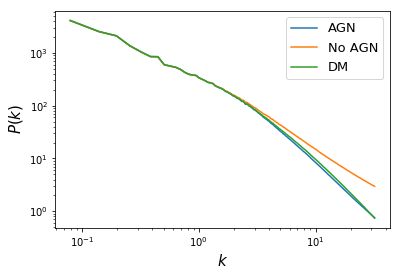

In [228]:
plt.loglog(k_agn,pk_agn,label='AGN')
plt.plot(k_no_agn,pk_no_agn,label='No AGN')
plt.plot(k_dm,pk_dm,label='DM')
plt.legend(fontsize=13);
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$P(k)$',fontsize=15);

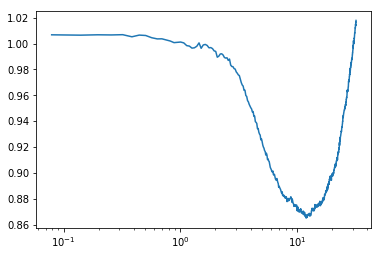

In [229]:
plt.semilogx(k_dm,pk_agn/pk_dm)

### Load in cosmological parameters

In [172]:
cosmo_params = {'Omega_cdm':(0.272-0.045),"Omega_b":0.045,"Omega_Lambda":0.728,"sigma8":0.81,"h":0.704,"n_s":0.967}

In [173]:
import sys
sys.path.append('/home/ophilcox/EffectiveHalos')
from EffectiveHalos import *

#### Run for DM sim

In [661]:
### fitted result of mead+15
odelta=300.#*cosm.cosmo.Omega_m()**(-0.352)

In [662]:
cosm = Cosmology(z_dm,npoints=10000,**cosmo_params)
mf = MassFunction(cosm,'Crocce')#Sheth-Tormen')#Tinker')#Bhattacharya')
hp = HaloPhysics(cosm,mf,'Duffy','NFW',npoints=1000,halo_overdensity='virial')

In [665]:
kk = k_agn[2:]
halop = HaloModel(cosm,mf,hp,kk)

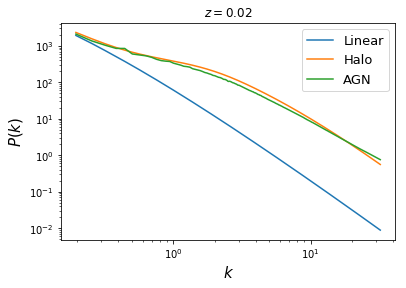

In [668]:
plt.loglog(kk,cosm.compute_linear_power(kk),label='Linear')
plt.loglog(kk,halop.halo_model(-1,-1,'Linear',0,0,0),label='Halo')
plt.plot(kk,pk_agn[2:],label='AGN')
plt.legend(fontsize=13);
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$P(k)$',fontsize=15);
plt.title(r'$z = %.2f$'%z_dm);

In [669]:
k = k_agn[2:]
Pk_obs = pk_agn[2:]
L_box = 100.
from scipy.optimize import minimize
from scipy.interpolate import interp1d

In [670]:
i11,i20 = pk_model(pp,return_terms=True)

In [671]:
def SHM(pars):
    return halop.halo_model(pars[0],pars[1],'Linear',0,0,0)
def EHM(pars):
    return halop.halo_model(pars[0],pars[1])
def one_halo(pars):
    return halop.I_20
def EHM_2(pars):
    return i11**2.*halop.non_linear_power(pars[0],pars[1])+i20

In [672]:
model = {'SHM':SHM,'EHM':EHM,'One Halo':one_halo}#,'EHM_2':EHM_2}
names = model.keys()

In [675]:
cols = ['red','blue','green','purple','orange','cyan','green']
k_fit = 1.
n_fit = np.where(k<k_fit)[0][-1]

print('Fitting up to %.2f'%k[n_fit])

#nbody_mean = all_Pk.mean(axis=0)
#nbody_std = all_Pk.std(axis=0)/np.sqrt(len(all_Pk))

# Define covariance parameters
dk = np.mean(np.diff(k))
survey_vol = L_box**3.
N_modes = k**2.*dk*survey_vol/(2.*np.pi**2.)

def fit_model(model):
    def chi2(par):
        pred = model(par)[:n_fit]
        cov_Pk_diag = pred**2.*2./N_modes[:n_fit]
        prec_diag = 1./cov_Pk_diag
        prec = np.diag(prec_diag)
        diff = pred - Pk_obs[:n_fit]#nbody_mean[:n_fit]
        chi2val = np.matmul(diff.T,np.matmul(prec,diff))
        return chi2val
    x = minimize(chi2,[1.,1.])
    return x.x

fit_pars = []
for n,name in enumerate(names):
    fit_par = fit_model(model[name])
    fit_pars.append(fit_par)

Fitting up to 0.94


('Model: "EHM", parameters: ', array([6.91342233, 3.07395376]))
('Model: "SHM", parameters: ', array([1., 1.]))
('Model: "One Halo", parameters: ', array([1., 1.]))


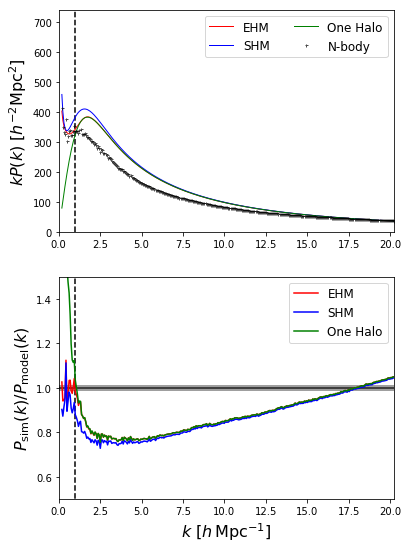

In [676]:
fig,ax = plt.subplots(2,1,figsize=(6,9))
ax[0].errorbar(k,k*Pk_obs,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
for n,name in enumerate(names):
    fit_par = fit_pars[n]
    print('Model: "%s", parameters: '%name,fit_par)
    pred = model[name](fit_par)
    alp = 1.
    lw = 1
    ax[0].plot(k,k*pred,label=name,alpha=alp,c=cols[n],lw=lw)
ax[0].legend(fontsize=12,ncol=2)
ax[0].set_ylim([0.,740])
ax[0].vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax[0].set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
#ax[0].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[0].set_xlim([0.01,20.2]);
#ax[0].set_xscale('log')

for n,name in enumerate(names):
    fit_par = fit_pars[n]
    pred = model[name](fit_par)
    ax[1].errorbar(k,Pk_obs/pred,label=name,alpha=alp,c=cols[n])
ax[1].set_ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{model}(k)$',fontsize=16)
ax[1].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[1].hlines(1.,0.001,100.,color='k',alpha=1)
ax[1].hlines([0.99,1.01],0.001,100.,color='k',alpha=0.5)
ax[1].vlines(k_fit,0,2,color='k',alpha=1.,linestyles='--')
ax[1].set_ylim([0.5,1.5])
#ax[1].set_xscale('log')
ax[1].legend(fontsize=12,ncol=1)
ax[1].set_xlim([0.01,20.2]);

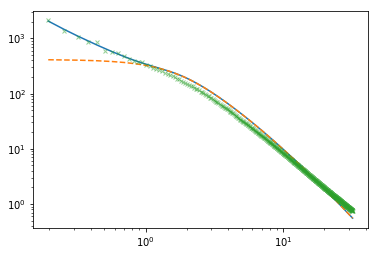

In [677]:
plt.loglog(k,EHM(fit_pars[0]))
plt.loglog(k,halop.I_20,ls='--')
#plt.loglog(k,halop.I_11**2.*cosm.compute_linear_power(k),ls='--')
plt.errorbar(k,Pk_obs,marker='x',ls='',ms=4,alpha=0.5);

#### Try to fit sims

In [679]:
from scipy.integrate import simps

In [680]:
def unnorm_profile(k_h,r_virial,c,nu_eta):
    r_scale = r_virial/c # in Mpc/h units

    # Check if we have an array or a float input and compute accordingly
    if type(k_h)==np.ndarray:
        # filter out sections with k_h<=0
        filt = np.where(k_h>0)

        # compute the matrix of r_scale * k_h
        ks0 = np.matmul(k_h.reshape(-1,1),(r_scale*nu_eta).reshape(1,-1))
        ks = ks0[filt,:]
    else:
        if k_h<=0.:
            return 1.
        ks = k_h*r_scale*nu_eta

    sici1 = sici(ks);
    sici2 = sici(ks*(1.+c))
    f1 = np.sin(ks)*(sici2[0]-sici1[0]);
    f2 = np.cos(ks)*(sici2[1]-sici1[1]);
    f3 = np.sin(c*ks)/(ks*(1.+c));
    fc = np.log(1.+c)-c/(1.+c);

    if type(k_h)==np.ndarray:
        output = np.ones_like(ks0)
        output[filt,:]=((f1+f2-f3)/fc)
        return output
    else:
        return (f1+f2-f3)/fc


In [681]:
cs2,R = fit_pars[0]
mi = halop.mass_integrals
dn_dm = mi._compute_mass_function()
b1 = mi._compute_linear_bias()
m_h = mi.m_h_grid
P_NL = halop.non_linear_power(cs2,R)

def conc(m_h,A=7.85,beta=-0.081):
    m_h_pivot = 2e12;
    return A*np.power(m_h/m_h_pivot,beta)*pow(cosm.a,0.71);
    
def pk_model(pars,return_terms=False):
    odelta,eta = pars
    
    def halo_profile(odelta,eta):
        rv = np.power(m_h*3.0/(4.0*np.pi*cosm.rhoM*odelta),1.0/3.0)

        sigma = cosm.sigma_logM_int(mi.logM_h_grid)
        nu = mf.delta_c/sigma
        
        # Compute halo concentration
        c = conc(m_h);
        # The function u is normalised to 1 for k<<1 so multiplying by M/rho turns units to a density in units normalized by h
        return unnorm_profile(kk,rv, c,nu**eta)*m_h/cosm.rhoM;

    m_u_m = halo_profile(odelta,eta)
    I_11 = simps(dn_dm*b1*m_u_m,mi.logM_h_grid,axis=1)

    # Do I_11 correction
    A = 1. - simps(dn_dm*b1*m_h/cosm.rhoM,mi.logM_h_grid)

    # compute window functions
    min_window = m_u_m[:,0]
    zero_window = m_h[0]/cosm.rhoM
    I_11 += A*min_window/zero_window

    I_20 = simps(dn_dm*m_u_m**2.,mi.logM_h_grid,axis=1)
    
    if return_terms:
        return I_11,I_20
    return I_11**2.*P_NL + I_20

In [682]:
n_fit = np.where(np.logical_and(k>1.5,k<20))[0][-1]

def fit_model(model):
    def chi2(par):
        pred = model(par)[:n_fit]
        cov_Pk_diag = (pred)**2.*2./N_modes[:n_fit]
        prec_diag = 1./cov_Pk_diag
        prec = np.diag(prec_diag)
        diff = pred - Pk_obs[:n_fit]#nbody_mean[:n_fit]
        chi2val = np.matmul(diff.T,np.matmul(prec,diff))
        return chi2val
    x = minimize(chi2,[300.,0.])
    return x.x

pp=fit_model(pk_model)

In [683]:
print(pp)

[5.85407125e+02 4.96130913e-01]


In [684]:
i11,i20 = pk_model(pp,return_terms=True)

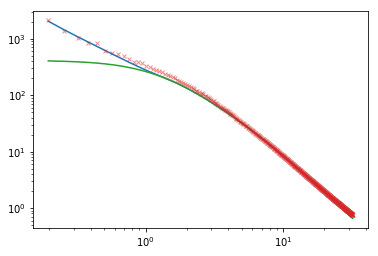

In [685]:
#plt.loglog(k,EHM(fit_pars[0]))
plt.loglog(k,pk_model(pp))#halop.I_20,ls='--')
plt.loglog(k,i11**2.*halop.non_linear_power(pp[-2],pp[-1]),ls='--')
plt.loglog(k,i20)
plt.errorbar(k,Pk_obs,marker='x',ls='',ms=4,alpha=0.5);

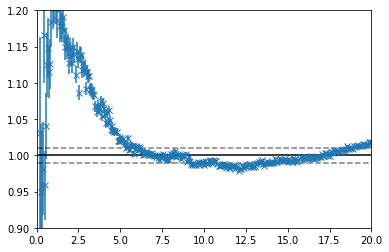

In [688]:
Pk_std = np.sqrt(Pk_obs**2.*2./N_modes)
plt.errorbar(k,Pk_obs/pk_model(pp),marker='x',yerr=Pk_std/pk_model(pp),ls='');
plt.xlim([0,20])
plt.ylim([0.9,1.2])
plt.hlines([0.99,1.01],0.,30,linestyles='--',color='k',alpha=0.5)
plt.hlines(1,0.,30,linestyles='-',color='k')